In [1]:
"""Mainly Edited for private usage by:  Ioannis Agriomallos
                                        Ioanna Mitsioni
License: BSD 3 clause

============= CURRENT CODE USAGE =============
Current code trains MLP Classifiers, to classify force input samples as stable (0) or slip (1)
---- Input
-> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 2 different datasets, 
   one training, containing several surfaces as well as slip-stable occurrences, 
   and one validation, containing 1 surface with slip-stable occurrences on a completely unseen task-setup.
---- Input transformation
-> Several pre-features can be taken from these inputs, but here |f| is kept.
-> Several time and frequency domain features are extracted from pre-feature windows. 
  (implemented in 'featext.py') These windows have size w and are shifted by s on each sample
-> Then a feature selection-ranking is performed using MutualVariableInformation
-> Finally PCA is performed to keep a reduced set among the best selected features
---- Training of ML Classifiers
-> Several MLP Classifiers are trained for all combinations of selected featuresets-datasets
---- Results
-> Stats of classification results are kept inside each .npz along with the respective trained model
"""
print(__doc__)
import time
start_time = time.time()
import numpy as np
from ml_training import *
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

Mainly Edited for private usage by:  Ioannis Agriomallos
                                        Ioanna Mitsioni
License: BSD 3 clause

============= CURRENT CODE USAGE =============
Current code trains MLP Classifiers, to classify force input samples as stable (0) or slip (1)
---- Input
-> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 2 different datasets, 
   one training, containing several surfaces as well as slip-stable occurrences, 
   and one validation, containing 1 surface with slip-stable occurrences on a completely unseen task-setup.
---- Input transformation
-> Several pre-features can be taken from these inputs, but here |f| is kept.
-> Several time and frequency domain features are extracted from pre-feature windows. 
  (implemented in 'featext.py') These windows have size w and are shifted by s on each sample
-> Then a feature selection-ranking is performed using MutualVariableInformation
-> Finally PCA is performed to keep a reduced 

In [2]:
class struct:
    def __init__(self):
        ####### TRAINING DEFAULTS
        self.cv = KFold(n_splits=5,random_state=42)
        self.scaler = StandardScaler() ;
        self.decomp = PCA(n_components=20)
        self.names = ["NearNb", "RBFSVM1", "MLP1", "RandFor"]
        self.classifiers = [KNeighborsClassifier(5),
                       SVC(gamma='auto', C=1),
                       MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
                       RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)]

        self.download = 1            # Download pre-computed (1) data or compute them all anew (0)
        self.delete_big_features = 0 # Delete (1) or keep (0) computed big-in-size features,
                                  # helping mainly to avoid several computations when recomputing features

        ############ INITIALISATION PARAMETERS ############
        self.window, self.shift = 1024, 20
        self.samplesperdataset = 10000
        self.havelabel = 1
        self.returntime = 0
        self.featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
        self.magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format,
        self.featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
        self.CV = 5                # cross validation checks
        self.numfeat = 10          # number of features to show
        self.nfeat = 1000          # number of features to keep
        ###### Initialize necessary names and paths
        self.datapath = 'data/'
        self.datafile = self.datapath+'dataset.npz'
        self.validfile = self.datapath+'validation.mat'
        self.featpath = self.datapath+'features/'+str(self.window)+'_'+str(self.shift)+'/'
        self.allfeatpath = self.featpath+'AllFeatures/'
        self.prefeatname = 'prefeatures'+'_'+str(self.window)+'_'+str(self.shift)+'_'+str(self.samplesperdataset)
        self.prefeatfile = self.featpath+self.prefeatname+'.npz'
        self.featname = 'features'+'_'+str(self.window)+'_'+str(self.shift)+'_'+str(self.samplesperdataset)
        self.featfile = self.featpath+self.featname+'.npz'
        self.validfeatname = 'valid'+self.featname
        self.validfeatfile = self.featpath+self.validfeatname+'.npz'
        self.surffile = self.featpath+self.featname+'_2fing_6surf.npz'
        self.XYfile = self.featpath+self.featname+'_XY.npz'
        self.XYsplitfile = self.featpath+self.featname+'_XYsplit.npz'
        self.validsurffile = self.featpath+self.validfeatname+'_2fing_6surf.npz'
        self.validXYfile = self.featpath+self.validfeatname+'_XY.npz'
        self.validXYsplitfile = self.featpath+self.validfeatname+'_XYsplit.npz'
        self.respath = self.datapath+'results'
        self.toolfile = self.datapath+'bargraph.zip'
        self.toolpath = self.datapath+'bargraph-rel_4_8/'
        self.tool = './'+self.toolpath+'bargraph.pl'
######### INITIALIZE OBJECT-STRUCT WITH PARAMETERS AND PASS THEM TO ML MODULE ########
c = struct()
m = ml(c)

In [3]:
######### DOWNLOAD NECESSARY FILES ###########
download_required_files()

Necessary  data/dataset.npz  already here!
Necessary  data/validation.mat  already here!
Necessary  data/features/1024_20/features_1024_20_10000.npz  already here!
Necessary  data/features/1024_20/validfeatures_1024_20_10000.npz  already here!
Desired trained models for 1 surface found!
Desired trained models for 2 surface found!
Desired trained models for 3 surface found!
Desired trained models for 4 surface found!
Desired trained models for 5 surface found!
Downloaded 1.2 GB of content in total!


In [4]:
############ TRAINING PROCEDURE ##############
# necessary steps before training
f,l,fd,member,m1,m2 = data_prep(c.datafile)                      # read input force and labels
prefeat = compute_prefeat(f)                                     # compute corresponding prefeatures
features, labels = feature_extraction(prefeat,member,c.featfile) # feature extraction from prefeatures
avg_feat_comp_time(prefeat)                                      # average feature extraction time
new_labels = label_cleaning(prefeat,labels,member)               # trim labels, around change points
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2,
                           c.XYfile,c.XYsplitfile)               # compute data and labels, trimmed and untrimmed
surf, surfla = computeXY_persurf(Xsp,Ysp,c.surffile)             # compute per surface data and labels
# training and offline testing
train_1_surface(surf,surfla)                                     # training of all combinations per 1 surface
train_2_surface(surf,surfla)                                     # training of all combinations per 2 surfaces
train_3_surface(surf,surfla)                                     # training of all combinations per 3 surfaces
train_4_surface(surf,surfla)                                     # training of all combinations per 4 surfaces
train_5_surface(surf,surfla)                                     # training of all combinations per 5 surfaces

---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------
1 -> f1: (36,) (36,) (36, 4)
2 -> f2: (36,) (36,) (36, 4)
3 -> f: (72,) (72,) (72, 4)
4 -> m1,m2: 36 36 1.0 1.0
5 -> f=f+l: (72,) : [(345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (130001, 4), (195001, 4), (65001, 4), (345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (6

---------------------------- Generating perf files for 1 surface -------------------------------------
---------------------------- Generating perf files for 2 surfaces ------------------------------------
---------------------------- Generating perf files for 3 surfaces ------------------------------------
---------------------------- Generating perf files for 4 surfaces ------------------------------------
---------------------------- Generating perf files for 5 surfaces ------------------------------------
---------------------------- Generating bar graphs for 1 surfaces ------------------------------------
---------------------------- Generating bar graphs for 2 surfaces ------------------------------------
---------------------------- Generating bar graphs for 3 surfaces ------------------------------------
---------------------------- Generating bar graphs for 4 surfaces ------------------------------------
---------------------------- Generating bar graphs for 5 surfaces -------

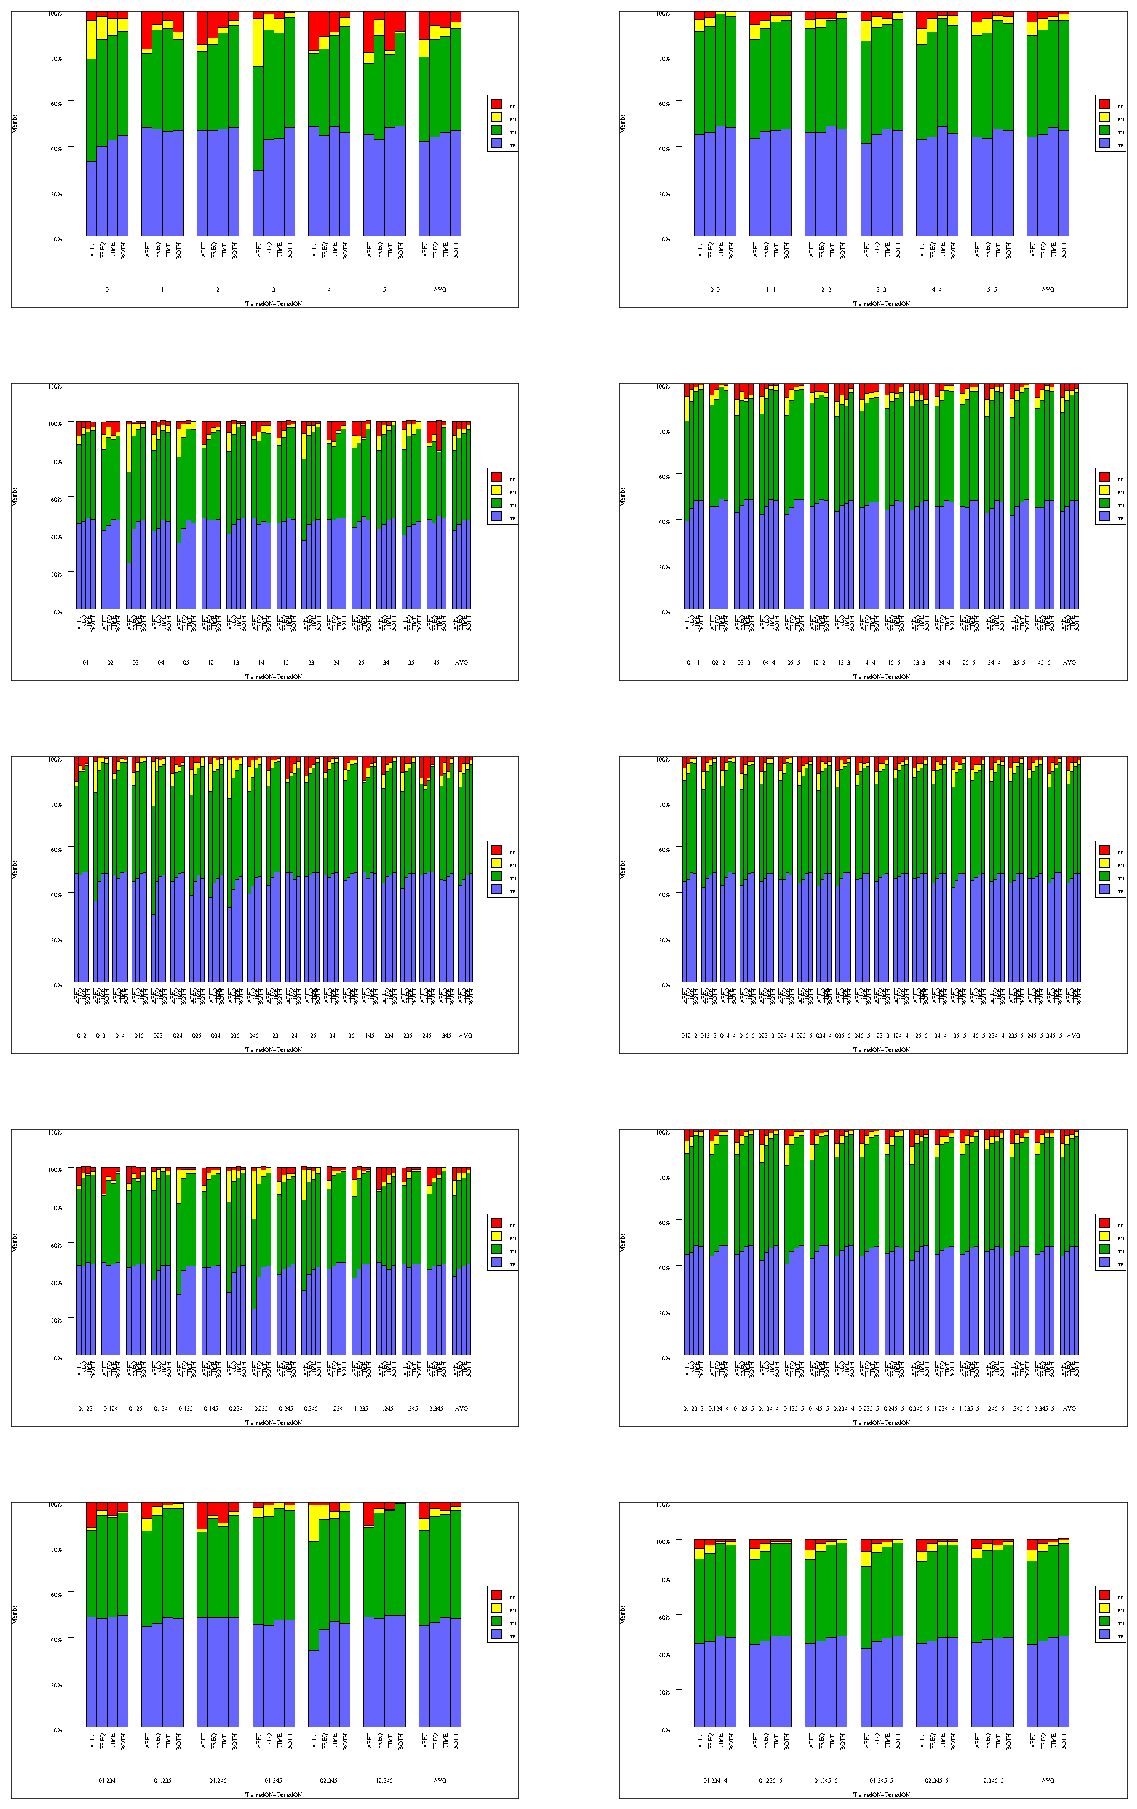

In [5]:
############ RESULT REPORTING ##############
# generate files with stats
bargraph_perf_gen1(6)
bargraph_perf_gen2(6)
bargraph_perf_gen3(6)
bargraph_perf_gen4(6)
bargraph_perf_gen5(6)
# use the bargraph tool to plot graphs from generated files
# -left column cross-accuracy (trained on one, tested on all the others), 
# -right column self-accuracy (trained and tested on the same)
# -each row i represents training only with i surfaces.
# -each stack represents a training group, each bar represents a subfeatureset(AFFT,FREQ,TIME,BOTH)
# -blue,green,yellow,red : TP,TN,FN,FP
plt.figure(figsize=(20,40))
for i in range(5):
    make_bargraphs_from_perf(i)

In [6]:
############ ONLINE TESTING PROCEDURE ##############
# same necessary steps as in training for data preparation
f,l,fd,member,m1,m2 = data_prep(c.validfile)
prefeat = compute_prefeat(f)
features, labels = feature_extraction(prefeat, member, c.validfeatfile, 'validfeat_')
new_labels = label_cleaning(prefeat,labels,member)
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2,c.validXYfile,c.validXYsplitfile)
surf, surfla = computeXY_persurf(Xsp,Ysp,c.validsurffile)

---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------
1 -> f1: (1, 1) (1, 1) (1, 1)
2 -> f2: (1, 1) (1, 1) (1, 1)
3 -> f: (2, 1) (2, 1) (2, 1)
4 -> m1,m2: 1 1 1.0 1.0
5 -> f=f+l: (2, 65000, 4) : [(65000, 4), (65000, 4)]
--------------------------------------- COMPUTING PREFEATURES ----------------------------------------
(2,) : [(65000, 2), (65000, 2)]
---------------------------------------- FEATURE EXTRACTION ------------------------------------------
Features FOUND PRECOMPUTED! Feature Loading DONE in: 1.06184911728 seconds 
features:  (2,) , labels:  (2,)
----------- KEEPING LABEL's PURE (STABLE, SLIP) PHASE PARTS (TRIMMING AROUND CHANGE POINTS)-----------
new_labels:  (2,)
----------------------------- COMPUTING X,Y for CLASSIFIERS' INPUT -----------------------------------
XY files FOUND PRECOMPUTED!
X,Y [0,1,2]:  (3199, 3107) (3199,) (3199, 3107) (3199,) (6398, 3107) (6398,)
Xsp,Ysp [0,1,2]:  (2769, 3107) (2769,) (2769, 3107) (276

(3199,) (2769,) (2769,)
(2650,) (2650,)


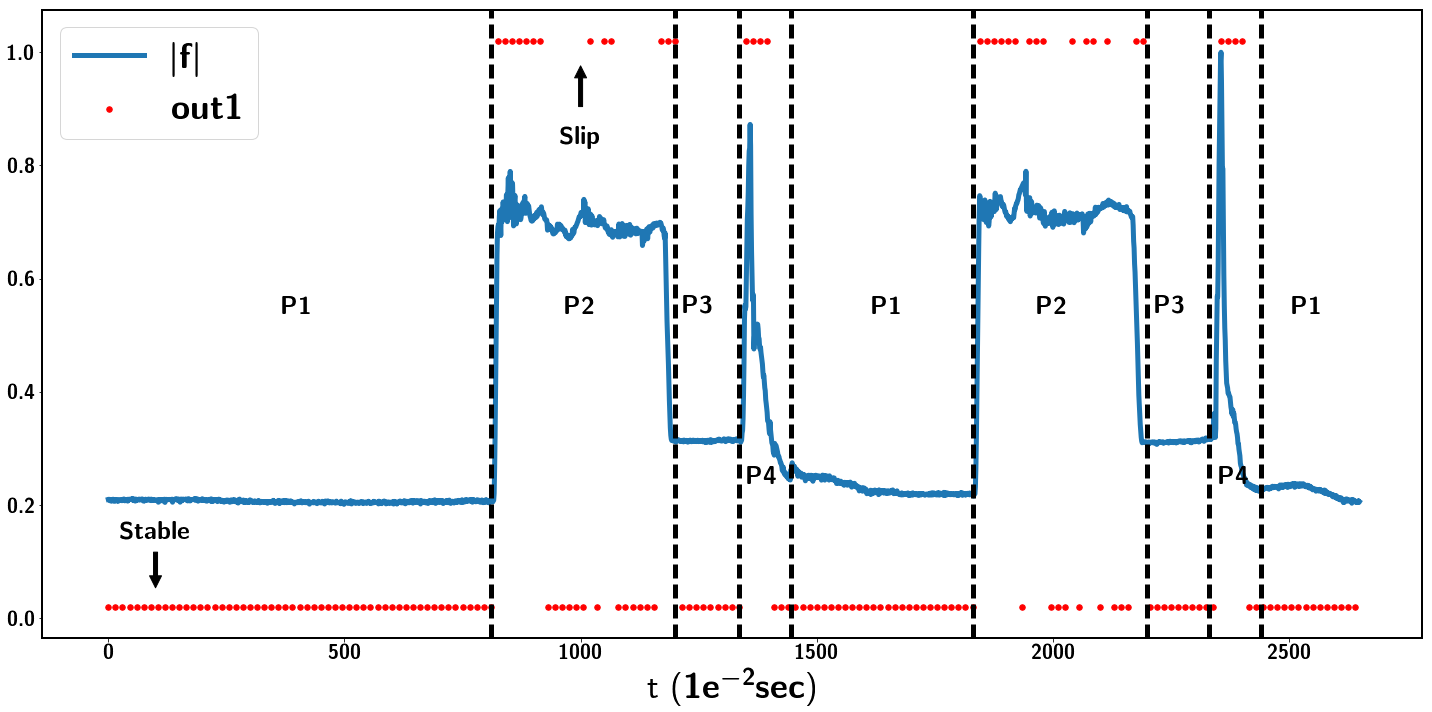

In [7]:
############ VISUALIZING ONLINE TESTING PROCEDURE ##############
window=c.window
subfeats = ['AFFT','FREQ','TIME','BOTH']
feats = ['fnorm','ftfn','fnormftfn']
matplotlib.rcParams['text.usetex'] = True

fileid = filename1(0,3,0,5)
fileidb = filename1(0,0,0,5)
fileid5 = filename5(0,3,0,1,2,3,4,5)
fileid5b = filename5(0,0,0,1,2,3,4,5)
model = np.load(fileid)['model'][0]
modelb = np.load(fileidb)['model'][0]
model5 = np.load(fileid5)['model'][0]
model5b = np.load(fileid5b)['model'][0]
Yout = model.predict(X[0])
Youtb = modelb.predict(Xsp[0][:,-window-2:-window/2-1])
Yout5 = model5.predict(Xsp[0])
Yout5b = model5b.predict(Xsp[0][:,-window-2:-window/2-1])
print Yout.shape, Yout5.shape, Yout5b.shape
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
offset = 2000-window
endset = 2650
skipf = 20
skipy = 15
ax = plt.figure(figsize=(20,10))
tf = np.linalg.norm(f[0][offset+window::skipf,:3][:endset],axis=1)
p1, = plt.plot(tf/max(tf),linewidth=5)
ty = Yout[offset/skipf:][:endset]+0.02
print tf.shape, ty.shape
p = plt.scatter(range(len(tf))[::skipy],ty[::skipy],color='red',s=30)
plt.hold
plt.text(100, 0.15, r'\textbf{Stable}', ha="center", va="center", rotation=0,
            size=25)
plt.text(1000, 0.85, r'\textbf{Slip}', ha="center", va="center", rotation=0,
            size=25)
plt.annotate('', fontsize=10, xy=(100, 0.05), xytext=(100, 0.12),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('', xy=(1000, 0.98), xytext=(1000, 0.9),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.text(400, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=810,linestyle='dashed',color='black',linewidth=5)
plt.text(1000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1200,linestyle='dashed',color='black',linewidth=5)
plt.text(1250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1335,linestyle='dashed',color='black',linewidth=5)
plt.text(1385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1445,linestyle='dashed',color='black',linewidth=5)
plt.text(1650, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1830,linestyle='dashed',color='black',linewidth=5)
plt.text(2000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2200,linestyle='dashed',color='black',linewidth=5)
plt.text(2250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2330,linestyle='dashed',color='black',linewidth=5)
plt.text(2385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2440,linestyle='dashed',color='black',linewidth=5)
plt.text(2540, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.xlabel(r't ($1e^{-2} sec$)',fontsize=35)
# plt.yticks([])
plt.legend([p1,p],[r'$|\textbf{f}|$',r'\textbf{out1}'],loc=2, prop={'size': 35})
plt.tick_params(labelsize=20)
plt.tight_layout()
savefig(c.datapath+'validation.pdf', bbox_inches='tight')


In [8]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_152Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_152Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.0N_kp3.5_152Hz_validation.mat
1.34205
1.34205
Accuracy for surface  0 0.907877169559 0.890520694259
TN(stable) and TP(slip) for surface  0 0.85100286533 0.9575 | 0.954154727794 0.835
Accuracy for surface  1 0.877169559413 0.949265687583
TN(stable) and TP(slip) for surface  1 0.862464183381 0.89 | 1.0 0.905
Accuracy for surface  2 0.907877169559 0.711615487316
TN(stable) and TP(slip) for surface  2 0.896848137536 0.9175 | 1.0 0.46
Accuracy for surface  3 0.891855807744 0.811748998665
TN(stable) and TP(slip) for surface  3 0.908309455587 0.8775 | 0.971346704871 0.6725
Accuracy for surface  4 0.851802403204 0.762349799733
TN(stable) and TP(slip) for surface  4 0.922636103152 0.79 | 1.0 0.555
Accuracy for surface  5 0.799732977303 0.630173564753
TN(stable) and TP(slip) for surface  5 1.0 0.625 | 1.0 0.3075
Accuracy for dataset    0.87271918113 0.792612372052
TN(stable) and TP(slip) for dataset  0.906876790831 0.842916666667 | 0.987583572111 0.6225
Filen

In [9]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3_152Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3_152Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation.mat
2.02426
2.02426
Accuracy for surface  0 0.739652870494 0.957276368491
TN(stable) and TP(slip) for surface  0 0.518624641834 0.9325 | 1.0 0.92
Accuracy for surface  1 0.874499332443 0.946595460614
TN(stable) and TP(slip) for surface  1 0.828080229226 0.915 | 1.0 0.9
Accuracy for surface  2 0.854472630174 0.903871829105
TN(stable) and TP(slip) for surface  2 0.787965616046 0.9125 | 1.0 0.82
Accuracy for surface  3 0.86782376502 0.889185580774
TN(stable) and TP(slip) for surface  3 0.833810888252 0.8975 | 1.0 0.7925
Accuracy for surface  4 0.929238985314 0.855807743658
TN(stable) and TP(slip) for surface  4 0.919770773639 0.9375 | 0.985673352436 0.7425
Accuracy for surface  5 0.891855807744 0.666221628838
TN(stable) and TP(slip) for surface  5 1.0 0.7975 | 1.0 0.375
Accuracy for dataset    0.859590565198 0.869826435247
TN(stable) and TP(slip) for dataset  0.8147086915 0.89875 | 0.997612225406 0.758333333333
Filename for pred

In [10]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_326Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_326Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.0N_kp3.5_326Hz_validation.mat
1.51563
1.51563
Accuracy for surface  0 0.849132176235 0.744993324433
TN(stable) and TP(slip) for surface  0 0.739255014327 0.945 | 0.621776504298 0.8525
Accuracy for surface  1 0.890520694259 0.877169559413
TN(stable) and TP(slip) for surface  1 0.905444126074 0.8775 | 0.994269340974 0.775
Accuracy for surface  2 0.851802403204 0.642189586115
TN(stable) and TP(slip) for surface  2 0.790830945559 0.905 | 0.974212034384 0.3525
Accuracy for surface  3 0.927903871829 0.777036048064
TN(stable) and TP(slip) for surface  3 0.977077363897 0.885 | 1.0 0.5825
Accuracy for surface  4 0.886515353805 0.628838451268
TN(stable) and TP(slip) for surface  4 0.948424068768 0.8325 | 0.942693409742 0.355
Accuracy for surface  5 0.781041388518 0.576769025367
TN(stable) and TP(slip) for surface  5 0.988538681948 0.6 | 0.957020057307 0.245
Accuracy for dataset    0.864485981308 0.707832665777
TN(stable) and TP(slip) for dataset  0.8915950334

In [11]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3_326Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3_326Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.5N_kp3_326Hz_validation.mat
1.8981
1.8981
Accuracy for surface  0 0.874499332443 0.929238985314
TN(stable) and TP(slip) for surface  0 0.822349570201 0.92 | 0.982808022923 0.8825
Accuracy for surface  1 0.71562082777 0.927903871829
TN(stable) and TP(slip) for surface  1 0.478510028653 0.9225 | 0.974212034384 0.8875
Accuracy for surface  2 0.794392523364 0.911882510013
TN(stable) and TP(slip) for surface  2 0.638968481375 0.93 | 0.974212034384 0.8575
Accuracy for surface  3 0.894526034713 0.893190921228
TN(stable) and TP(slip) for surface  3 0.882521489971 0.905 | 1.0 0.8
Accuracy for surface  4 0.922563417891 0.866488651535
TN(stable) and TP(slip) for surface  4 0.948424068768 0.9 | 0.988538681948 0.76
Accuracy for surface  5 0.894526034713 0.695594125501
TN(stable) and TP(slip) for surface  5 1.0 0.8025 | 1.0 0.43
Accuracy for dataset    0.849354695149 0.870716510903
TN(stable) and TP(slip) for dataset  0.795128939828 0.896666666667 | 0.98662846227

In [12]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_836Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_836Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.0N_kp3.5_836Hz_validation.mat
1.42474
1.42474
Accuracy for surface  0 0.815754339119 0.781041388518
TN(stable) and TP(slip) for surface  0 0.681948424069 0.9325 | 0.744985673352 0.8125
Accuracy for surface  1 0.866488651535 0.710280373832
TN(stable) and TP(slip) for surface  1 0.85100286533 0.88 | 0.785100286533 0.645
Accuracy for surface  2 0.865153538051 0.611481975968
TN(stable) and TP(slip) for surface  2 0.873925501433 0.8575 | 0.779369627507 0.465
Accuracy for surface  3 0.882510013351 0.694259012016
TN(stable) and TP(slip) for surface  3 0.945558739255 0.8275 | 0.747851002865 0.6475
Accuracy for surface  4 0.893190921228 0.699599465955
TN(stable) and TP(slip) for surface  4 0.962750716332 0.8325 | 0.80229226361 0.61
Accuracy for surface  5 0.833110814419 0.420560747664
TN(stable) and TP(slip) for surface  5 1.0 0.6875 | 0.395415472779 0.4425
Accuracy for dataset    0.859368046284 0.652870493992
TN(stable) and TP(slip) for dataset  0.885864374

In [13]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3.5_836Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3.5_836Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.5N_kp3.5_836Hz_validation.mat
7.66321
7.66321
Accuracy for surface  0 0.802561366062 0.827107790822
TN(stable) and TP(slip) for surface  0 0.767908309456 0.823129251701 | 0.644699140401 0.93537414966
Accuracy for surface  1 0.837780149413 0.93916755603
TN(stable) and TP(slip) for surface  1 0.839541547278 0.836734693878 | 0.977077363897 0.916666666667
Accuracy for surface  2 0.918890074707 0.836712913554
TN(stable) and TP(slip) for surface  2 0.942693409742 0.904761904762 | 0.868194842407 0.818027210884
Accuracy for surface  3 0.849519743863 0.886872998933
TN(stable) and TP(slip) for surface  3 0.957020057307 0.785714285714 | 0.905444126074 0.875850340136
Accuracy for surface  4 0.931696905016 0.797225186766
TN(stable) and TP(slip) for surface  4 0.971346704871 0.908163265306 | 0.78223495702 0.80612244898
Accuracy for surface  5 0.779082177161 0.614727854856
TN(stable) and TP(slip) for surface  5 0.753581661891 0.794217687075 | 0.977077363897 0.3996

In [14]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1N_kp3_nofilt_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1N_kp3_nofilt_validation_rot.mat')

Filename for prediction: ati_new_fd1N_kp3_nofilt_validation.mat
1.44638
1.44638
Accuracy for surface  0 0.866488651535 0.937249666222
TN(stable) and TP(slip) for surface  0 0.799426934097 0.925 | 0.965616045845 0.9125
Accuracy for surface  1 0.859813084112 0.891855807744
TN(stable) and TP(slip) for surface  1 0.793696275072 0.9175 | 0.9111747851 0.875
Accuracy for surface  2 0.883845126836 0.643524699599
TN(stable) and TP(slip) for surface  2 0.873925501433 0.8925 | 0.638968481375 0.6475
Accuracy for surface  3 0.913217623498 0.837116154873
TN(stable) and TP(slip) for surface  3 0.951289398281 0.88 | 0.948424068768 0.74
Accuracy for surface  4 0.894526034713 0.761014686248
TN(stable) and TP(slip) for surface  4 0.925501432665 0.8675 | 0.893982808023 0.645
Accuracy for surface  5 0.879839786382 0.580774365821
TN(stable) and TP(slip) for surface  5 0.988538681948 0.785 | 0.968481375358 0.2425
Accuracy for dataset    0.882955051179 0.775255896751
TN(stable) and TP(slip) for dataset  0.888

In [15]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3_nofilt_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3_nofilt_validation_rot.mat')

Filename for prediction: ati_new_fd1.5N_kp3_nofilt_validation.mat
1.84994
1.84994
Accuracy for surface  0 0.825100133511 0.871829105474
TN(stable) and TP(slip) for surface  0 0.727793696275 0.91 | 0.876790830946 0.8675
Accuracy for surface  1 0.719626168224 0.782376502003
TN(stable) and TP(slip) for surface  1 0.495702005731 0.915 | 0.63323782235 0.9125
Accuracy for surface  2 0.909212283044 0.728971962617
TN(stable) and TP(slip) for surface  2 0.908309455587 0.91 | 0.696275071633 0.7575
Accuracy for surface  3 0.877169559413 0.895861148198
TN(stable) and TP(slip) for surface  3 0.876790830946 0.8775 | 1.0 0.805
Accuracy for surface  4 0.923898531375 0.853137516689
TN(stable) and TP(slip) for surface  4 0.968481375358 0.885 | 0.991404011461 0.7325
Accuracy for surface  5 0.882510013351 0.560747663551
TN(stable) and TP(slip) for surface  5 0.994269340974 0.785 | 0.994269340974 0.1825
Accuracy for dataset    0.856252781486 0.782153983089
TN(stable) and TP(slip) for dataset  0.82855778414

## Scaled Version of one of the above on the following ranges (0.1, 0.5, 1.0, 2.0, 5.0, 20.0)

In [16]:
for sc in [0.1, 0.5, 1.0, 2.0, 5.0, 20.0]:
    print "-------- SCALING = ",sc,"--------"
    ####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
    prediction('ati_new_fd1.5N_kp3_152Hz_validation.mat',scale=sc)
    ####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
    prediction('ati_new_fd1.5N_kp3_152Hz_validation_rot.mat',scale=sc)

-------- SCALING =  0.1 --------
Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation.mat
2.02426
0.202426
Accuracy for surface  0 0.947930574099 0.628838451268
TN(stable) and TP(slip) for surface  0 0.939828080229 0.955 | 1.0 0.305
Accuracy for surface  1 0.958611481976 0.631508678238
TN(stable) and TP(slip) for surface  1 0.965616045845 0.9525 | 1.0 0.31
Accuracy for surface  2 0.961281708945 0.465954606142
TN(stable) and TP(slip) for surface  2 0.991404011461 0.935 | 1.0 0.0
Accuracy for surface  3 0.957276368491 0.465954606142
TN(stable) and TP(slip) for surface  3 0.991404011461 0.9275 | 1.0 0.0
Accuracy for surface  4 0.897196261682 0.465954606142
TN(stable) and TP(slip) for surface  4 0.853868194842 0.935 | 1.0 0.0
Accuracy for surface  5 0.994659546061 0.465954606142
TN(stable) and TP(slip) for surface  5 1.0 0.99 | 1.0 0.0
Accuracy for dataset    0.952825990209 0.520694259012
TN(stable) and TP(slip) for dataset  0.957020057307 0.949166666667 | 1.0 0.1025
Filename for p

Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation_rot.mat
1.39025
2.7805
Accuracy for surface  0 0.852476290832 0.883034773446
TN(stable) and TP(slip) for surface  0 0.872495446266 0.825 | 0.894353369763 0.8675
Accuracy for surface  1 0.750263435195 0.841938883035
TN(stable) and TP(slip) for surface  1 0.688524590164 0.835 | 0.761384335155 0.9525
Accuracy for surface  2 0.801896733404 0.893572181243
TN(stable) and TP(slip) for surface  2 0.812386156648 0.7875 | 0.918032786885 0.86
Accuracy for surface  3 0.938883034773 0.933614330875
TN(stable) and TP(slip) for surface  3 0.972677595628 0.8925 | 0.950819672131 0.91
Accuracy for surface  4 0.691253951528 0.868282402529
TN(stable) and TP(slip) for surface  4 0.471766848816 0.9925 | 0.803278688525 0.9575
Accuracy for surface  5 0.883034773446 0.880927291886
TN(stable) and TP(slip) for surface  5 0.825136612022 0.9625 | 0.998178506375 0.72
Accuracy for dataset    0.819634703196 0.883561643836
TN(stable) and TP(slip) for dataset 

## Scaled Version of one of the above on the following ranges (0.1, 0.5, 1.0, 2.0, 5.0, 20.0)
## with DC cancellation

In [4]:
for sc in [0.1, 0.5, 1.0, 2.0, 5.0, 20.0]:
    print "-------- SCALING = ",sc,"--------"
    ####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
    prediction('ati_new_fd1.5N_kp3_152Hz_validation.mat',scale=sc,fdes=1.5)
    ####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
    prediction('ati_new_fd1.5N_kp3_152Hz_validation_rot.mat',scale=sc,fdes=1.5)

-------- SCALING =  0.1 --------
Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation.mat
Accuracy for surface  0 0.949265687583 0.628838451268
F1score for surface   0 0.952618453865 0.467432950192
TN(stable) and TP(slip) for surface  0 0.942693409742 0.955 | 1.0 0.305
Accuracy for surface  1 0.958611481976 0.631508678238
F1score for surface   1 0.960907944515 0.473282442748
TN(stable) and TP(slip) for surface  1 0.965616045845 0.9525 | 1.0 0.31
Accuracy for surface  2 0.961281708945 0.465954606142
F1score for surface   2 0.962676962677 0.0
TN(stable) and TP(slip) for surface  2 0.991404011461 0.935 | 1.0 0.0
Accuracy for surface  3 0.957276368491 0.465954606142
F1score for surface   3 0.958656330749 0.0
TN(stable) and TP(slip) for surface  3 0.991404011461 0.9275 | 1.0 0.0
Accuracy for surface  4 0.897196261682 0.465954606142
F1score for surface   4 0.906666666667 0.0
TN(stable) and TP(slip) for surface  4 0.853868194842 0.935 | 1.0 0.0
Accuracy for surface  5 0.994659546061 0

/home/jagrio/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy for dataset    0.953048509123 0.520694259012
F1score for dataset    0.955737361024 0.185941043084
TN(stable) and TP(slip) for dataset  0.957497612225 0.949166666667 | 1.0 0.1025
Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation_rot.mat
Accuracy for surface  0 0.936775553214 0.578503688093
F1score for surface   0 0.928741092637 0.0
TN(stable) and TP(slip) for surface  0 0.907103825137 0.9775 | 1.0 0.0
Accuracy for surface  1 0.985247629083 0.578503688093
F1score for surface   1 0.98275862069 0.0
TN(stable) and TP(slip) for surface  1 0.976320582878 0.9975 | 1.0 0.0
Accuracy for surface  2 0.950474183351 0.578503688093
F1score for surface   2 0.937912813738 0.0
TN(stable) and TP(slip) for surface  2 0.99635701275 0.8875 | 1.0 0.0
Accuracy for surface  3 0.988408851423 0.578503688093
F1score for surface   3 0.986058301648 0.0
TN(stable) and TP(slip) for surface  3 1.0 0.9725 | 1.0 0.0
Accuracy for surface  4 0.841938883035 0.578503688093
F1score for surface   4 0.82638

Accuracy for surface  4 0.754339118825 0.921228304406
F1score for surface   4 0.804670912951 0.928657799274
TN(stable) and TP(slip) for surface  4 0.532951289398 0.9475 | 0.876790830946 0.96
Accuracy for surface  5 0.918558077437 0.762349799733
F1score for surface   5 0.917456021651 0.713826366559
TN(stable) and TP(slip) for surface  5 1.0 0.8475 | 1.0 0.555
Accuracy for dataset    0.836671117045 0.907654650645
F1score for dataset    0.859062980031 0.911983032874
TN(stable) and TP(slip) for dataset  0.727316141356 0.932083333333 | 0.921203438395 0.895833333333
Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation_rot.mat
Accuracy for surface  0 0.851422550053 0.884088514226
F1score for surface   0 0.823529411765 0.863184079602
TN(stable) and TP(slip) for surface  0 0.872495446266 0.8225 | 0.896174863388 0.8675
Accuracy for surface  1 0.814541622761 0.845100105374
F1score for surface   1 0.791469194313 0.838283828383
TN(stable) and TP(slip) for surface  1 0.799635701275 0.835 | 0

## Check the training forces and compare them with testing ones (2.86 1.35 2.12 1.68)

In [17]:
printit = False
f,_,_,_,_,_ = data_prep(c.datafile,printit=printit)                        # read training input force
pf = compute_prefeat(f,printit=printit)                                  # compute corresponding prefeatures
fv,_,_,_,_,_ = data_prep(c.validfile,printit=printit)                      # read validation input force
pfv = compute_prefeat(fv,printit=printit)                                # compute corresponding prefeatures

atifiles = ['ati_new_fd1.0N_kp3.5_152Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_152Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3_152Hz_validation.mat',
            'ati_new_fd1.5N_kp3_152Hz_validation_rot.mat',
            'ati_new_fd1.0N_kp3.5_326Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_326Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3_326Hz_validation.mat',
            'ati_new_fd1.5N_kp3_326Hz_validation_rot.mat',
            'ati_new_fd1.0N_kp3.5_836Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_836Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3.5_836Hz_validation.mat',
            'ati_new_fd1.5N_kp3.5_836Hz_validation_rot.mat',
            'ati_new_fd1N_kp3_nofilt_validation.mat',
            'ati_new_fd1N_kp3_nofilt_validation_rot.mat',
            'ati_new_fd1.5N_kp3_nofilt_validation.mat',
            'ati_new_fd1.5N_kp3_nofilt_validation_rot.mat']
atiftr = []
atifrt = []
for filen in atifiles:
    tf,_,_,_,_,_ = data_prep(c.datapath+filen,k=1,printit=printit)
    ptf = compute_prefeat(tf,printit=printit)
    if filen[-7:-4] == 'rot':
        atifrt.append(ptf)
    else:
        atiftr.append(ptf)
atiftr = np.array(atiftr).flatten()
atifrt = np.array(atifrt).flatten()

plist = [pf, pfv, atiftr, atifrt]
pname = ['train', 'valid','atitran','atirot']
print pf.shape, pfv.shape, atiftr.shape, atifrt.shape
mf, mfst, mfsl = np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))
print 'datasetname: [all/stable/slip:[0:mean, 1:max, 2:min, 3:std]]'
for ind in range(len(plist)):
    pt = plist[ind]
    # 0:mean, 1:max, 2:min, 3:std
    for p in range(len(pt)):
        mf[ind,0] += np.mean(pt[p][:,0])
        mf[ind,1] += np.max(pt[p][:,0])
        mf[ind,2] += np.min(pt[p][:,0])
        mf[ind,3] += np.std(pt[p][:,0])
        stind = pt[p][:,1]==0
        slind = pt[p][:,1]==1
        mfst[ind,0] += np.mean(pt[p][stind,0])
        mfst[ind,1] += np.max(pt[p][stind,0])
        mfst[ind,2] += np.min(pt[p][stind,0])
        mfst[ind,3] += np.std(pt[p][stind,0])
        mfsl[ind,0] += np.mean(pt[p][slind,0])
        mfsl[ind,1] += np.max(pt[p][slind,0])
        mfsl[ind,2] += np.min(pt[p][slind,0])
        mfsl[ind,3] += np.std(pt[p][slind,0])
    mf[ind,0] /= len(plist[ind])
    mf[ind,1] /= len(plist[ind])
    mf[ind,2] /= len(plist[ind])
    mf[ind,3] /= len(plist[ind])
    mfst[ind,0] /= len(plist[ind])
    mfst[ind,1] /= len(plist[ind])
    mfst[ind,2] /= len(plist[ind])
    mfst[ind,3] /= len(plist[ind])
    mfsl[ind,0] /= len(plist[ind])
    mfsl[ind,1] /= len(plist[ind])
    mfsl[ind,2] /= len(plist[ind])
    mfsl[ind,3] /= len(plist[ind])
    print pname[ind], mf[ind], mfst[ind], mfsl[ind]

(72,) (2,) (48,) (48,)
datasetname: [all/stable/slip:[0:mean, 1:max, 2:min, 3:std]]
train [ 2.86251015  5.09840423  1.49469399  0.98215772] [ 2.18675048  3.03727431  1.72562893  0.28885944] [ 3.66916912  5.09562958  1.51392494  0.8716188 ]
valid [ 1.34931022  3.08346999  0.6870942   0.76446083] [ 0.7360613   1.01612632  0.6870942   0.07938595] [ 1.64921946  3.08346999  0.69021954  0.76977593]
atitran [ 1.7081888   4.31136074  0.49442186  0.64149739] [ 1.47028108  1.67330645  1.22426491  0.13014016] [ 1.92579317  4.31136074  0.49605079  0.80594714]
atirot [ 1.66960896  2.3169749   1.01502636  0.23922276] [ 1.59671116  1.85347776  1.3185732   0.12934402] [ 1.77400117  2.31319775  1.06879374  0.26144718]
